# FPL Team Selection and Weekly prediction

Recently I've been getting back into soccer Fantasy Premier League (FPL) again after trying it many years ago. The last I played it, I abandoned it mid-season as it was too much to keep with with - team news, player injuries, who's playing well and who's not, who's playing who... There are just too many moving parts and I had more important things to do (e.g. play FIFA).

The new season has just started and I thought - why not offload all this thinking to an ML model to predict the player points each week, and also come up with an algorithm to determine which transfer(s) I should make each week? This notebook is the result of that.

Unfortunately I couldn't get the model up in time before the start of the season. Either way, I will be using the 19/20 season to test/validate my model, and apply it to the current season thus far (starting from GW 5).


## Acknowledgements

- I obtained the data from `vaastav` at https://github.com/vaastav/Fantasy-Premier-League, which is a really rich source of well-organized player and gameweek data, dating back to the 15/17 season.
- The team IDs were inconsistent across seasons, which is a pain, but fortunately `solpaul` has a nice file here that tracks the changes across seasons:  https://github.com/solpaul/fpl-prediction/blob/master/data/teams.csv
- In terms of modeling, I drew inspiration from the following sources:
    - https://medium.com/@sol.paul/how-to-win-at-fantasy-premier-league-using-data-part-1-forecasting-with-deep-learning-bf121f38643a#http://www.philipkalinda.com/ds9.html
    - http://www.philipkalinda.com/ds9.html

## Brief Intro

The Fantasty Premier League (FPL) is a fantasy football (soccer) league in which you score points based on a player's real-life performance on the football pitch. In the current instantiation of the FPL (19/20):

- 

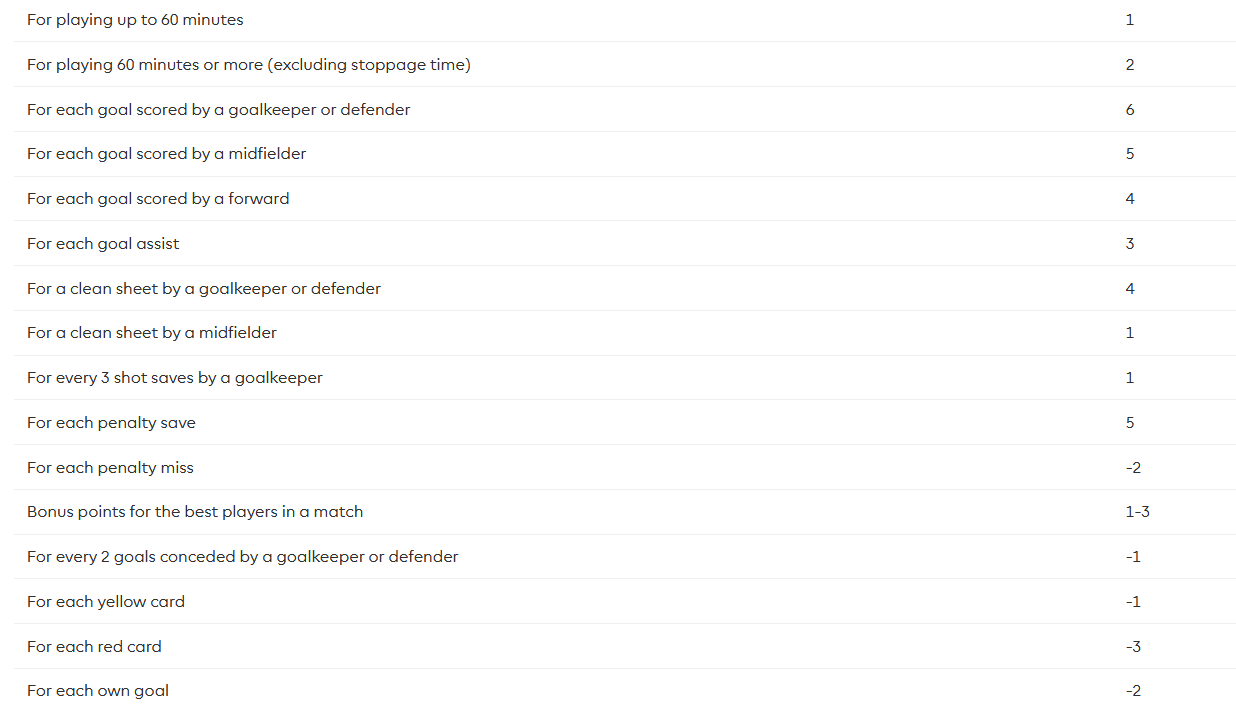

In [1]:
!pip install -Iv pulp==1.6.8 --quiet

  Using cached https://files.pythonhosted.org/packages/39/92/8486ede85fcc088f1b3dba4ce92dd29d126fd96b0008ea213167940a2475/pyparsing-3.1.1-py3-none-any.whl


In [257]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import os

import time

import scipy.stats as stats

import pulp

import unidecode

In [260]:
## Read data

# Players df contains the summary of player performance from each season
# Each row represents one player

## GWs df contains the information of each player for each gameweek
## Each row represents a player's performance for a gameweek

folderpath = '../data/input/fantasypremierleague/'

players_1617_df = pd.read_csv(folderpath+'players_raw_1617.csv', encoding='latin')
players_1718_df = pd.read_csv(folderpath+'players_raw_1718.csv', encoding='latin')
players_1819_df = pd.read_csv(folderpath+'players_raw_1819.csv', encoding='latin')
players_1920_df = pd.read_csv(folderpath+'players_raw_1920.csv', encoding='latin')
players_2021_df = pd.read_csv(folderpath+'players_raw_2021.csv', encoding='latin')
players_2122_df = pd.read_csv(folderpath+'players_raw_2122.csv', encoding='latin')
players_2223_df = pd.read_csv(folderpath+'players_raw_2223.csv', encoding='latin')

gws_1617_df = pd.read_csv(folderpath+'merged_gw_1617.csv', encoding='latin')
gws_1718_df = pd.read_csv(folderpath+'merged_gw_1718.csv',encoding='latin')
gws_1819_df = pd.read_csv(folderpath+'merged_gw_1819.csv',encoding='latin')
gws_1920_df = pd.read_csv(folderpath+'merged_gw_1920.csv',engine='python', encoding='latin')
gws_2021_df = pd.read_csv(folderpath+'merged_gw_2021.csv', encoding='latin')
gws_2122_df = pd.read_csv(folderpath+'merged_gw_2122.csv',encoding='latin', on_bad_lines='skip')
gws_2223_df = pd.read_csv(folderpath+'merged_gw_2223.csv',encoding='latin')

team_codes_df = pd.read_csv('../data/teams.csv')


In [261]:
# Clean the headers to be used later
team_codes_df.columns.values[2:] = team_codes_df.columns[2:].str.replace('team_', '')

## Clean and process dataframes


For both types of dataframes, I want to add:
- Player position
- Full name (since the names are inconsistent across seasons and between dataframes)



Also, it turns out that there are 2 Danny Wards in the 18/19 season. I am still thinking of a good way to represent both. But, since the are both fringe players in that season (total of 0 points between them), I will remove them for now (sorry!)




In [262]:
# remove Danny Wards from 18/19 season
players_1819_df = players_1819_df[((players_1819_df.first_name == "Danny") & (players_1819_df.second_name=="Ward"))==False]
gws_1819_df = gws_1819_df[gws_1819_df.name.str.contains("Danny_Ward")==False]

In [263]:
player_df_list = [players_1617_df, players_1718_df, players_1819_df, players_1920_df, players_2021_df, players_2122_df, players_2223_df]
gw_df_list = [gws_1617_df, gws_1718_df, gws_1819_df, gws_1920_df, gws_2021_df, gws_2122_df, gws_2223_df]

In [264]:
# append season and season index to dfs

seasons = ['1617', '1718', '1819', '1920', '2021', '2122', '2223']
season_nums = list(range(len(seasons)))

for i in range(len(seasons)):
    
    player_df_list[i]['season'] = seasons[i]
    gw_df_list[i]['season'] = seasons[i]
    
    player_df_list[i]['season_num'] = season_nums[i]
    gw_df_list[i]['season_num'] = season_nums[i]

In [265]:
# combine dataframes from all seasons into one

players_df = pd.concat(player_df_list)
gws_df = pd.concat(gw_df_list)

players_df.reset_index(inplace=True)
gws_df.reset_index(inplace=True)

In [282]:
def get_full_name_playerdf(first_name, second_name):
    full_name = first_name +'_' + second_name
    full_name = full_name.replace(" ", "_")
    full_name = full_name.replace("-", "_")
    full_name = unidecode.unidecode(full_name)
       
    return full_name

In [267]:
# Translate player positions into string for easier readability

positions_dict = {
    1: 'Keeper',
    2: 'Defender',
    3: 'Midfielder',
    4: 'Forward'   
}

players_df['full_name'] = players_df.apply(lambda x: get_full_name_playerdf(x.first_name, x.second_name), axis=1).str.lower()
players_df['position'] = players_df.element_type.map(positions_dict)
players_df['starting_cost'] = players_df.now_cost - players_df.cost_change_start_fall
players_df['cost_bin'] = players_df.now_cost.apply(lambda x: np.floor(x/10))

gws_df['full_name'] = gws_df.name.str.replace('_\d+','')
gws_df['full_name'] = gws_df['full_name'].str.replace(" ", "_").str.replace("-", "_").str.replace('_\d+','')
gws_df['full_name'] = gws_df['full_name'].apply(lambda x: unidecode.unidecode(x))
gws_df['full_name'] = gws_df['full_name'].str.lower()

C:\Users\bourd\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app
C:\Users\bourd\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()


In [268]:
    
def clean_gw_df(player_df, gw_df, team_codes_df):
    
    # Returns a df with player position, player's team name, and opponent's team name
    
    pdf = player_df.copy()[['full_name', 'season', 'position', 'player_team_name']]
    gdf = gw_df.copy()
    
    gdf = gdf.merge(pdf, on=['full_name', 'season'], how='left')
    
    
    dfs = []
    for s, group in gdf.groupby('season'):

        temp_code_df = team_codes_df[['team', s]]
        temp_code_df = temp_code_df.dropna()
        
        group = group[['opponent_team']]
        group['opponent_team_name'] = group.opponent_team.map(temp_code_df.set_index(s).team)
        dfs.append(group[['opponent_team_name']])
        
    out_df = pd.concat(dfs, axis=0)
    out_df = pd.concat([gdf, out_df], axis=1)

    return out_df



In [269]:
gws_df.opponent_team = gws_df.opponent_team.astype(float)
players_df['player_team_name'] = players_df.team_code.map(team_codes_df.set_index('team_code').team)
gws_df = clean_gw_df(players_df, gws_df, team_codes_df)

C:\Users\bourd\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Approach

To get the initial team, I will rely on a simple method of picking the players with the most points based on last season.

A brief recap on the current the FPL rules:

1. A team must have 15 players
2. A team must have:
   - 2 Goalkeepers
   - 5 Defenders
   - 5 Midfielders
   - 3 Forwards
3. The total value of the initial squad must not exceed 100 million
4. There can only be a maximum of 3 players from a single team
5. Only the starting 11 will gain points for the FPL team
6. A captain's score is doubled. 
7. Each gameweek, one free transfer is allowed. Each additional transfer will cost 4 points (not money!) 

Due to the complexity of the FPL mechanism, I have chosen to focus only on the above rules for now. There are also other rules that I plan on incorporating into my model:

8. If a player in the starting 11 is unavailable (due to injury or suspension etc.), they will be substituted by the first player on the bench.
9. If the captain is unavailable, the vice-captain's score is doubled instead.
10. If the free transfer each week is not used, it can be carried over to the next Gameweek (for a maximum of 2 free transfers for a given Gameweek).
11. There are a number of wildcards that can boost the points obtained in a Gameweek


I will first use a linear programming approach to optimize the initial team. Then, I will build a regression model to forecast the predicted points for each player for each Gameweek, and use a heuristic-based algorithm to determine the best transfer (if any) to make for each Gameweek.


## Picking the initial team of 15 players

I decided to go with the simple approach of using the performance of players in the previous season (18/19) as the basis of selection into the team. Using linear programming, I will optimize for the maximum number of points scored in the 18/19 season, with the following constraints:

- Total budget of 1000 
- 1 keeper
- 4 defenders
- 4 midfielders
- 2 forwards
- not more than 3 players from the same team

Since benched players do not contribute to Gameweek points, I will first pick the 4 cheapest players (1 from each position) in order to maximize the amount of money I can use for the starting 11. To do this, I simply

Since I am using the 19/20 season as the test set, I will use the 18/19 season to pick my initial team.

First, let's get the players who are available in the current season. This is necessary because some players would have been relegated/promoted after the previous season, and also because players would have been transferred between clubs (of different leagues).

In [283]:
def make_available_players_df(this_season_player_df, last_season_player_df):
    
    
    last_season_player_df = last_season_player_df[last_season_player_df.minutes > 0]
    last_season_player_df = last_season_player_df[['full_name', "total_points"]]
    last_season_player_df.rename(columns={'total_points': "total_points_last_season"},
                                inplace=True)
    
    available_players_df = pd.merge(this_season_player_df,
                                    last_season_player_df,
                                   on='full_name', how='left')
    
    available_players_df.total_points_last_season = available_players_df.groupby(['position', 'cost_bin', 'team_code']).total_points_last_season.transform(lambda x: x.fillna(x.mean()))
    
    return available_players_df

In [284]:
current_season_player_df = players_df[players_df.season=='2223'] 
previous_season_player_df = players_df[players_df.season=='2122'] 

available_players_df = make_available_players_df(current_season_player_df, previous_season_player_df)


In [285]:
def get_cheapest_players(player_df):
    
    cheapest_player_names = []
    total_cost = 0
    
    # for each position, sort the players by cost (in ascending order)
    # then, get the player with the most number of points
    
    for position, group in player_df.groupby('position'):
        cheapest_players =  group[(group.starting_cost == group.starting_cost.min())]
        top_cheapest_player = cheapest_players[cheapest_players.total_points == cheapest_players.total_points.max()]
        
        cheapest_player_name = top_cheapest_player.full_name.values[0]
        
        cheapest_player_names += [cheapest_player_name]
        total_cost += top_cheapest_player.starting_cost.values[0]
        
        print(position, ": ", cheapest_player_name )
        
    return cheapest_player_names, total_cost

In [286]:
bench_players, bench_cost = get_cheapest_players(available_players_df)
print(bench_cost)

Defender :  daniel_amartey
Forward :  sam_greenwood
Keeper :  stefan_ortega_moreno
Midfielder :  leon_bailey
140


### Optimizing for starting 11

Now that I have my bench players, I'll go ahead and optimize for the starting 11. Again, here I am using the actual results of the previous season. The reasoning here is that, at least for the first Gameweek, the players who are most likely to perform well are the players who have performed well in the last season (in the absence of other information). Of course, one can also try to predict the total number of points a player will score in the current season, but in the absence of any information about the current season, I am doubtful that the prediction will be meaningful or fare better than this simple heuristic. This is something that I am planning to look into soon!

First, a bunch of helper functions to make life easier:

In [287]:
def make_decision_variables(player_df):
    return [pulp.LpVariable(i, cat="Binary") for i in player_df.full_name]

In [288]:
def make_optimization_function(player_df, decision_variables):
    op_func = ""

    for i, player in enumerate(decision_variables):
        op_func += player_df.total_points_last_season[i]*player
        
    return op_func

In [289]:
def make_cash_constraint(player_df, decision_variables, available_cash):
    total_paid = ""
    for rownum, row in player_df.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                formula = row['starting_cost']*player
                total_paid += formula

    return (total_paid <= available_cash)

In [290]:
def make_player_constraint(position, n, decision_variables, player_df):
    
    total_n = ""
    
    player_positions = player_df.position
    
    for i, player in enumerate(decision_variables):
        if player_positions[i] == position:
            total_n += 1*player
            
    return(total_n == n)

In [291]:
def add_team_constraint(prob, player_df, decision_variables):

    for team, group in player_df.groupby('team_code'):
        team_total = ''
        
        for player in decision_variables:
            if player.name in group.full_name.values:
                formula = 1*player
                team_total += formula
                
        prob += (team_total <= 3)

In [292]:
available_cash = 1000 - bench_cost

prob = pulp.LpProblem('InitialTeam', pulp.LpMaximize)

decision_variables = make_decision_variables(available_players_df)
prob += make_optimization_function(available_players_df, decision_variables)
prob += make_cash_constraint(available_players_df, decision_variables, available_cash)
prob += make_player_constraint("Keeper", 1, decision_variables, available_players_df) 
prob += make_player_constraint("Defender", 4, decision_variables, available_players_df) 
prob += make_player_constraint("Midfielder", 4, decision_variables, available_players_df) 
prob += make_player_constraint("Forward", 2, decision_variables, available_players_df)

add_team_constraint(prob, available_players_df, decision_variables)

In [293]:
## Solve

prob.writeLP('InitialTeam.lp')
optimization_result = prob.solve()

PulpError: Repeated variable names in Lp format
[('ben_davies', 2)]

In [24]:
## Get initial team

def get_initial_team(prob, player_df):
    
    variable_names = [v.name for v in prob.variables()]
    variable_values = [v.varValue for v in prob.variables()]

    initial_team = pd.merge(pd.DataFrame({'full_name': variable_names,
                  'selected': variable_values}),
                                       player_df, on="full_name")
    
    initial_team = initial_team[initial_team.selected==1.0] 
    
    return initial_team

    

In [25]:
initial_team_df = get_initial_team(prob, available_players_df)
initial_team_df[['full_name', "position", "starting_cost", "player_team_name"]]

,full_name,position,starting_cost,player_team_name
43,andrew_robertson,Defender,70,Liverpool
69,aymeric_laporte,Defender,61,Manchester City
107,callum_wilson,Forward,68,Bournemouth
163,david_luiz_moreira_marinho,Defender,54,Arsenal
243,gylfi_sigurdsson,Midfielder,66,Everton
343,jordan_pickford,Keeper,49,Everton
474,mohamed_salah,Midfielder,125,Liverpool
535,pierre_emerick_aubameyang,Forward,108,Arsenal
540,raheem_sterling,Midfielder,120,Manchester City
572,ryan_fraser,Midfielder,61,Bournemouth


In [26]:
## Sanity check

def sanity_check(team_df):
    print('Sanity check for starting 11: ')
    print('*'*88) 
    
    print('Number of players in each position: ')
    for pos, group in team_df.groupby('position'):
        print(pos, ': ', len(group), sep='')
        
    
    print('*'*88)   
    print('Number of players from each team: ')
    print(team_df.groupby('player_team_name').position.count())
    
    print('*'*88)    
    print('Total cost:', team_df.starting_cost.sum())
    


In [27]:
sanity_check(initial_team_df)

Sanity check for starting 11: 
****************************************************************************************
Number of players in each position: 
Defender: 4
Forward: 2
Keeper: 1
Midfielder: 4
****************************************************************************************
Number of players from each team: 
player_team_name
Arsenal            2
Bournemouth        2
Everton            2
Liverpool          3
Manchester City    2
Name: position, dtype: int64
****************************************************************************************
Total cost: 847


## Performance of initial team

Right off the bat, how does this team fare in the 19/20 season?

Note: I selected the highest scoring player in the 18/19 season as the captain for the 19/20 season

In [28]:
captain = get_initial_team(prob, previous_season_player_df).sort_values("total_points", ascending=False).head(1).full_name.values[0]

In [29]:
captain = get_initial_team(prob, previous_season_player_df).sort_values("total_points", ascending=False).head(1).full_name.values[0]

total_points = current_season_player_df[current_season_player_df.full_name.isin(initial_team_df.full_name)].total_points.sum()
total_points += current_season_player_df[current_season_player_df.full_name==captain].total_points

print("Total points for 19/20 season:", total_points.values[0])

Total points for 19/20 season: 1792


How does this compare to the rest of the FPL managers? Unfortunately there is no data available on historic FPL manager ranking, but with some Googling I managed to find someone with the exact same score of 1792 in the 19/20 season (https://fantasy.premierleague.com/entry/299659/history)

This manager ranked 4375672. According to https://www.premierleague.com/news/1252542, there were 7.6 million managers last season. This translates to a final standing of the top 57.57% of managers. Not bad, but not great either.

This initial score was calculated based on a strategy of "set it and forget it" - once the initial team was selected, the captain was selected as well, and I just left it to run for the whole season. No wildcards were played, no transfers were made, and no substitutions were made (so, in some weeks, a player could have had 0 points because they were not playing - but, I have yet to check if this is true for this team).

Next, I will take a look at how we can improve this score by making weekly transfers!

# Modeling

## Approach:

- Use each player's performance in previous Gameweeks to predict total points for this Gameweek.
- Use team and opponent performance in previous Gameweeks as well

This will be done by creating lagged versions of selected features such as cumulative goals scored/conceded by the player's team as well as their opponent. Each player's contribution will also be taken into account by creating the corresponding lagged features at the player level, as well by incorporating what FPL clas the "ICT" variables - intensity, creativty, and threat - which related to a player's performance on the pitch that did not directly relate to goals (but relate to creating goal-scoring opportunities and build-up play)


- Use previous Gameweek's performance to predict total points for next gameweek
- Calculate a rolling average
- Also use previous season's total points as a predictor, as the predictions for the earlier gameweeks might be extremely noisy. This is important as we don't want star players to be transfered out just because they had a bad start
- For players without data from past seasons, replace with average of players in the same position and similar cost (rounded to nearest 10m)

- Only include players who had played (i.e. minutes > 0) to reduce noise

Again, some helper functions to make life easier:

In [30]:
def get_team_points(was_home, h_score, a_score):
    
    if h_score == a_score:
        return 1
    
    if h_score > a_score:
        if was_home:
            return 3
        else: 
            return 0
    
    if h_score < a_score:
        if was_home:
            return 0
        else: 
            return 3

In [31]:
def get_opponent_points(team_points):
    if team_points == 1:
        return 1
    
    if team_points == 3:
        return 0
    
    if team_points == 0:
        return 3

In [32]:
gws_df['team_points']= gws_df.apply(lambda x: get_team_points(x.was_home, x.team_h_score, x.team_a_score), axis=1)
gws_df['opponent_points'] = gws_df.team_points.apply(lambda x: get_opponent_points(x))

In [33]:
def player_lag_features(gw_df, features, lags):
    
    out_df = gw_df.copy()
    lagged_features = []
    
    for feature in features:
            
        for lag in lags:
            
            lagged_feature = 'last_' + str(lag) + '_' + feature
            
            if lag == 'all':
                out_df[lagged_feature] = out_df.sort_values('round').groupby(['season', 'full_name'])[feature]\
            .apply(lambda x: x.cumsum() - x)
                
            else:

                out_df[lagged_feature] = out_df.sort_values('round').groupby(['season', 'full_name'])[feature]\
                .apply(lambda x: x.rolling(min_periods=1, window=lag+1).sum() - x)

            lagged_features.append(lagged_feature)
    
    return out_df, lagged_features

In [34]:
def team_lag_features(gw_df, features, lags):
    out_df = gw_df.copy()
    lagged_features = []
    
    for feature in features:

        ## Create a df for each feature
        ## Then, self-join so that the opponent info for that feature is included
        ## Then, create lagged features and join the columns to the feature df
        ## Do the same for the opponent feature
        ## Exit loop, merge with the original df
        
        feature_name = feature + '_team'
        opponent_feature_name = feature_name + '_opponent'
        
  
        feature_team = out_df.groupby(['player_team_name', 'season', 'round', 'kickoff_time', 'opponent_team_name'])\
                        [feature].max().rename(feature_name).reset_index()
        
        # self join to get opponent info
        
        feature_team = feature_team.merge(feature_team,
                          left_on=['player_team_name', 'season', 'round', 'kickoff_time', 'opponent_team_name'],
                          right_on=['opponent_team_name', 'season', 'round', 'kickoff_time', 'player_team_name'],
                          how='left',
                          suffixes=('', '_opponent'))
            
        

        
        for lag in lags:
            lagged_feature_name = 'last_' + str(lag) + '_' + feature_name
            lagged_opponent_feature_name = 'opponent_last_' + str(lag) + '_' + feature
            

            if lag == 'all':
                
                feature_team[lagged_feature_name] = feature_team.sort_values('round').groupby('player_team_name')[feature_name]\
                                                .apply(lambda x: x.cumsum() - x)
            
                feature_team[lagged_opponent_feature_name] = feature_team.groupby('player_team_name')[opponent_feature_name]\
                                                .apply(lambda x: x.cumsum() - x)
            else:
                    
                       
                feature_team[lagged_feature_name] = feature_team.sort_values('round').groupby('player_team_name')[feature_name]\
                                                    .apply(lambda x: x.rolling(min_periods=1,
                                                                              window=lag+1).sum()-x)

                feature_team[lagged_opponent_feature_name] = feature_team.groupby('player_team_name')[opponent_feature_name]\
                                                    .apply(lambda x: x.rolling(min_periods=1,
                                                                              window=lag+1).sum()-x)

            lagged_features.extend([lagged_feature_name, lagged_opponent_feature_name])
            
        out_df = out_df.merge(feature_team,
                             on=['player_team_name', 'season', 'round', 'kickoff_time', 'opponent_team_name'],
                             how='left')
        
        
        return out_df, lagged_features

In [35]:
player_features_to_lag = [
    'assists',
     'bonus',
     'bps',
     'creativity',
     'clean_sheets',
     'goals_conceded',
     'goals_scored',
     'ict_index',
     'influence',
     'minutes',
     'threat']

team_features_to_lag = ['goals_conceded', 'goals_scored', 'team_points', 'opponent_points']

In [36]:
lagged_gw_df_players, lagged_player_features = player_lag_features(gws_df, player_features_to_lag, ['all', 1, 3, 5])

In [37]:
lagged_gw_df, lagged_team_features = team_lag_features(lagged_gw_df_players, team_features_to_lag, ['all', 1, 3, 5])

In [38]:
relevant_features = ['position', 'was_home', 'minutes', 'value', 'round', 'season_num'] + \
    lagged_player_features + \
    lagged_team_features 

# Modelling



In [39]:
def make_dummies(df, numerical_features, categorical_features):
    
  
    X_num = df[numerical_features]
    X_cat = df[categorical_features]
    
    X_cat = X_cat.astype(str)
    X_cat = pd.get_dummies(X_cat)
    
    # Join categorical and numerical features
    X = pd.concat([X_num, X_cat], axis=1)
    
    return X

In [40]:
categorical_features = ['was_home', 'position']
numerical_features = numerical_features = list(set(relevant_features) - set(categorical_features))

In [41]:
train_df = lagged_gw_df[(lagged_gw_df.season!='1920')]
test_df = lagged_gw_df[(lagged_gw_df.season=='1920') ]



In [42]:
# XGBoost handles NA values, but the other scikit learn methods (that I've chosen) do not

lagged_gw_df_no_na = lagged_gw_df.dropna(subset=relevant_features + ['total_points', 'season'])
train_df_no_na = lagged_gw_df_no_na[lagged_gw_df_no_na.season!='1920']
test_df_no_na = lagged_gw_df_no_na[lagged_gw_df_no_na.season=='1920']

In [43]:
X_train = make_dummies(train_df[relevant_features], numerical_features, categorical_features)
y_train = train_df.total_points

X_train_no_na = make_dummies(train_df_no_na[relevant_features], numerical_features, categorical_features)
y_train_no_na = train_df_no_na.total_points

In [44]:
X_test = make_dummies(test_df, numerical_features, categorical_features)
y_test = test_df.total_points

X_test_no_na = make_dummies(test_df_no_na, numerical_features, categorical_features)
y_test_no_na = test_df_no_na.total_points

# Regression models

For a start, I have chosen to look at:

- Linear regression and its variants, Lasso and Ridge
- XGBoost
- A simple baseline model of using group means

For the XGBoost regressor, I will first do a randomized search to tune the hyperparameters. One risk of this approach is that time and resources will be wasted on tuning the hyperparameters if it turns out that a much simpler model that doesn't require hyperparameter tuning (e.g. linear regression) performs much better than XGBoost. But, given that XGBoost has known to almost always outperform most other models, it is at least worth a shot.

Then, all models will be compared and the top 2 (with the highest cross-validation score - here I use RMSE) will be used to make predictions to be fed into the algorithm to select potential transfers for each gameweek.

A brief explanation on the starting values I have selected for the tuning of the hyperparameters:

`max_depth`: larger values makes the model (1) more complex, (2) more likely to overfit, and (3) take longer to train. Here, I used a range from 3-6 (the default). I am wary of overfitting since the nature of the data can change dramatically across seasons (e.g. due to player transfers, improvement/decline of play abilities, state of the club etc.). 

`min_child_weight`: Similar to `max_depth`, I want to reduce the complexity/variance in the model. Here, larger values will reduce the likelihood of overfitting. I decided to use a range from 6-10

`learning_rate`: The default here is 0.3. I decided to try 5 values: 1/10 of the default, 1/5 of the default, 1.5x the default, and 2x the default.

`subsample` and `colsample_by_tree`: The default here is 1, but since I want to reduce overfitting, I decided to use a range from 0.8 - 0.9. 



In [45]:
params = {
         'max_depth': list(range(3,7)),  
    'min_child_weight': list(range(10,51)),
    'learning_rate':  [0.03, 0.15, 0.3, 0.45, 0.6],
    'subsample': stats.uniform(0.8, 0.1),
    'colsample_bytree': [0.8, 0.1]}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')
xgb_reg.fit(X_train, y_train)



xgb_cv = RandomizedSearchCV(xgb_reg, params, cv=3, scoring='neg_root_mean_squared_error',
                            random_state=999)


In [46]:
xgb_cv.fit(X_train, y_train)
xgb_best = xgb.XGBRegressor(objective='reg:squarederror')
xgb_best.set_params(**xgb_cv.best_params_)


XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.8, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.03, max_delta_step=None, max_depth=6,
             min_child_weight=37, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.8412357788312058,
             tree_method=None, validate_parameters=None, verbosity=None)

In [47]:
# Initialize the models. I am doing it this way as predictions are easy to calculate so I will not be storing them until I need them


seed = 999
models = []
models.append(('LinReg', LinearRegression()))
models.append(('LassoReg', LassoCV()))
models.append(('RidgeReg', RidgeCV()))


In [48]:
def get_cv_scores(models, X, y, k=5, seed=999):
    
    # inspired by the excellent tutorial by Jason Brownlee:
    # https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
    
    names = []
    results = []
    print("Cross val scores:")
    
    for name, m in models:
        cv_results = -cross_val_score(m, X, y, cv=k, scoring='neg_root_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        
        print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std() ))
        print("")
        print("*"*88)
        print("")
        
    return names, results


In [49]:
model_names, model_results = get_cv_scores(models, X_train_no_na, y_train_no_na)

Cross val scores:
LinReg: 1.899590 (0.048375)

****************************************************************************************

LassoReg: 1.904346 (0.050299)

****************************************************************************************

RidgeReg: 1.899542 (0.048351)

****************************************************************************************



In [50]:
xgb_cv_scores = get_cv_scores([("XGB", xgb_best)], X_train, y_train)

Cross val scores:
XGB: 1.855922 (0.049368)

****************************************************************************************



In [51]:
model_names += xgb_cv_scores[0]
model_results += xgb_cv_scores[1]

In [52]:
def compare_model_scores(model_names, model_results):
    
    fig = plt.figure()
    fig.suptitle('Model comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(model_results)
    ax.set_xticklabels(model_names)
    plt.show()

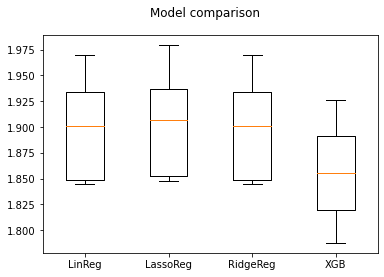

In [53]:
compare_model_scores(model_names, model_results)

It looks like XGBoost is the winner here in terms of average RMSE. The other regression models appear to be more or less the same, so I will go with the simple Linear Regression model as the other choice for comparing the transfer selection algorithm.

# Transfer selection

Next, I came up with a heuristic-based algorithm that will decide which transfer, if any, to make for each Gameweek:

- For each player position, find the player in the current team with the lowest predicted points. Here, I excluded the Keeper since the variance in points (and thus the potential benefit from a transfer) from Keepers is not very high compared to the other positions.
- From the pool of players not in the current team, get all players that (1) have predicted points that are higher than this player, and (2) a cost that is lower than the cost of this player and the current available money
- From this pool of players, a potential player will be selected. 
- Among the 3 potential players selected (1 from each position), the player with the highest predicted point difference, compared against the player that they will replace, will be selected as the final player to be transferred in. 
- The constraint of not more than 3 players from the same team will also be checked.
- There could be cases where all the players from the current team have the highest predicted points for their respective positions. In that case, no transfers will be made.

In [54]:
def make_predicted_table(y_test, y_pred, gw_df):
    results_df = pd.DataFrame(list(zip(y_test.tolist(), y_pred.tolist())),
                             columns=["actual", "predicted"])
    
    
    results_df.reset_index(drop=True, inplace=True)
    gw_df.reset_index(inplace=True)
    pred_df = pd.concat([gw_df, results_df], axis=1)
    
    return pred_df

In [55]:
def get_suggested_transfer(predicted_df, team_list, current_money):
    
    predicted_diff = 0
    money_change = 0
    suggested_in = ''
    suggested_out = ''
    team_df = predicted_df[(predicted_df.full_name.isin(team_list))]
    
  
    teams_dict = {}
    for i, row in team_df.iterrows():
        if row.player_team_name not in teams_dict:
            teams_dict[row.player_team_name] = [row.full_name]
        else:
            teams_dict[row.player_team_name].append(row.full_name)
            
            
    for position in ["Defender", "Midfielder", "Forward"]:
        
        # don't bother about keepers, variance in scores is not that great
        # so, save the free transfer for other positions
       
        
        
        player_df = predicted_df[predicted_df.position==position].sort_values('predicted', ascending=False).reset_index()

        
        lowest_pos = 0
        player_names = team_df[team_df.position==position].full_name.values
        
        # loop through the players for this position, and get the rank (row number) of the player with the lowest predicted score
        for p in player_names:
            player_pos = player_df[player_df.full_name==p].index[0]
            if player_pos > lowest_pos:
                lowest_pos = player_pos
                potential_out = p
                potential_out_cost = team_df[team_df.full_name==p].value.values[0]
                potential_out_team = team_df[team_df.full_name==p].player_team_name.values[0]
                
            elif len(player_names) <= 1:
                potential_out_cost = 0
                potential_out_team = 'none'
                potential_out = 'none'
                
        # get all players above this player
        potential_players = player_df[:lowest_pos]
        
        
        # only keep players that we can afford
        potential_players = potential_players[potential_players.value <= potential_out_cost + current_money]
        
        # only keep players who played (need a better way of doing this)
        potential_players = potential_players[potential_players.minutes > 0]

        # get the prediction difference for each suggested player
        # select the one with the highest difference as the suggested transfer (compare across positons)
        
        potential_out_predicted = team_df[team_df.full_name==p].predicted.values[0]
        
        for i, row in potential_players.iterrows():
                
            # skip if it is a player we already have
            if row.full_name in team_list:
                continue



            # if there are no other players of the same team, it's ok to consider this player
            # if not, check whether there are 3 players of the same team already
            if row.player_team_name not in teams_dict:
                pass
            else:
                if len(teams_dict[row.player_team_name]) == 3:
                    # if there are already 3 players of the same team,
                    # can't take another player of the same team
                    # unless the suggested_out is the same team as suggested_in (direct swap)
                   
                    if row.player_team_name == potential_out_team:
                        pass
                    else:
                        continue
                else:
                    pass
                
            
            # check for difference in predictions
            if row.predicted - potential_out_predicted > predicted_diff:
                predicted_diff = row.predicted - potential_out_predicted
                suggested_in = row.full_name
                suggested_out = potential_out
                
                # calculate change in money
                money_change = potential_out_cost - row.value
                
    return suggested_in, suggested_out, money_change

In [56]:
def get_score(team_list, gw_df):
    
    gw_score = gw_df[gw_df.full_name.isin(team_list)].actual.sum() \
        + gw_df[(gw_df.full_name.isin(team_list)) & (gw_df.position!='Keeper')].sort_values("predicted", ascending=False).head(1).actual.values[0]
        
    
    return gw_score

In [57]:
def get_performance(team_list, starting_money, gw_list,
                   prediction_df):
    
    current_money = starting_money
    total_score = 0
    
    
    in_list = []
    out_list = []
    score_list = []
    unplayed_list = []
    
    
    for gw in gw_list:

        gw_df = prediction_df[prediction_df.GW==gw]
        money_change = 0
        suggested_in = ''
        suggested_out = ''
        if gw > 1:
            

            suggested_in, suggested_out, money_change = get_suggested_transfer(gw_df, team_list, current_money)
        
            current_money += money_change

            team_list.append(suggested_in)
            team_list.remove(suggested_out)
            
        

        ## Calculate scores
        
        gw_score = get_score(team_list, gw_df)

        
        out_list.append(suggested_out)
        in_list.append(suggested_in)
        score_list.append(gw_score)
        
        total_score += gw_score
        
    out_df = pd.DataFrame({'GW': gw_list,
                          'player_in': in_list,
                          'player_out': out_list,
                          'total_score': score_list})
    
    print(total_score)
    
    return(out_df)

In [58]:
## Get predictions for the two best models, Linear Regression and XGBoost

lin_reg = LinearRegression()
lin_reg.fit(X_train_no_na, y_train_no_na)
linreg_predictions = lin_reg.predict(X_test_no_na)


xgb_best.fit(X_train, y_train)
xgb_predictions = xgb_best.predict(X_test)

In [59]:
predicted_df_lin_reg = make_predicted_table(y_test_no_na, linreg_predictions, test_df_no_na[relevant_features + ['full_name', 'GW', 'player_team_name', 'total_points']] )
predicted_df_xgb = make_predicted_table(y_test, xgb_predictions, test_df[relevant_features + ['full_name', 'GW', 'player_team_name', 'total_points']] )

# Model comparison

First, a reminder of the total points that would have been obtained without any transfers:

In [60]:
captain = get_initial_team(prob, previous_season_player_df).sort_values("total_points", ascending=False).head(1).full_name.values[0]

total_points = current_season_player_df[current_season_player_df.full_name.isin(initial_team_df.full_name)].total_points.sum()
total_points += current_season_player_df[current_season_player_df.full_name==captain].total_points

print("Total points for 19/20 season:", total_points.values[0])

Total points for 19/20 season: 1792


In [61]:
## Linear regression

my_team = list(initial_team_df.full_name)
gameweeks = (test_df.GW).unique()
starting_money = 1000 - bench_cost - initial_team_df.starting_cost.sum()

lin_reg_perf = get_performance(my_team, starting_money, gameweeks,
                   predicted_df_lin_reg)

2041


The linear regression model gives a end-of-season score of 2041. Linear regression shows a huge improvement of about 250 points! This corresponds to a ranking of 1457242 (https://fantasy.premierleague.com/entry/222484/history/), or about the top 19% of all managers. Great improvement from 57% just with a simple linear regression model! 

What about XGBoost?

In [62]:
## XGBoost


my_team = list(initial_team_df.full_name)
gameweeks = (test_df.GW).unique()
starting_money = 1000 - bench_cost - initial_team_df.starting_cost.sum()

xgb_cv_perf = get_performance(my_team, starting_money, gameweeks,
                   predicted_df_xgb)

2278


The XGBoost model gives a end-of-season score of 2219. A more modest, but still substantial, improvement over the linear regression model. This corresponds to a ranking of 79192, or about top 1% of all managers (https://fantasy.premierleague.com/entry/104879/history). XGBoost allowed the team to climb more than 15% ranking points compared to linear regression! Furthermore, I was able to achieve a top 1% ranking! 


In [64]:
xgb_cv_perf

,GW,player_in,player_out,total_score
0,1.0,,,90
1,2.0,bernardo_mota_veiga_de_carvalho_e_silva,ryan_fraser,40
2,3.0,,,59
3,4.0,,,53
4,5.0,,,62
5,6.0,riyad_mahrez,raheem_sterling,70
6,7.0,harry_kane,callum_wilson,55
7,8.0,felipe_anderson_pereira_gomes,gylfi_sigurdsson,33
8,9.0,bamidele_alli,riyad_mahrez,40
9,10.0,alexandre_lacazette,harry_kane,41


## Statistical analysis

The total points obtained by the two different models definitely different, but is this difference greater than what would be expected by random chance alone? For example, suppose that the XGBoost regressor resulted in 1 more point that the linear regression model. This difference would likely be due to chance, and we might be better off just using the simpler model.

Here, I conducted a paired-samples t-test to determine whether the better performance of the XGBoost model was due to chance:

In [63]:
stats.ttest_rel(xgb_cv_perf.total_score, lin_reg_perf.total_score)

Ttest_relResult(statistic=2.747528199595008, pvalue=0.009223559959750473)

Since p = .009, the null hypothesis of "no difference in the predicted points between the linear regression and XGBoost model" is rejected (at alpha = .05). Thus, I am confident that there is a meaningful difference between the two models, and that the XGBoost provides better predicted points for the 19/20 FPL season.

# Final thoughts

As Box once said, "All models are wrong, but some are useful". As with all models, we cannot achieve 100% accuracy (ignoring edge cases e.g. a system where the data is deterministic - input of X always gives Y). Models can and do sometimes go wrong, and it would be important to have a human in the loop to determine whether the suggested transfer makes sense or not. For example, the model sometimes makes questionable transfers, such as bringing in Dele Alli for Heung Min Son (Gameweek 28) Nicholas Pepe for Kevin de Bruyne (Gameweek 45). For someone who has been following the 19/20 season, these would raise eyebrows given the excellent form that the "transferred out" players were in.  

Either way, the final model seems to perform well in the 19/20 season. I am excited to test this out in the 20/21 season, and hopefully make it to the top 1% as predicted!

# To-do:

- Add more data sources, e.g. FIFA/Football Manager ratings, bookmaker odds etc.
- Add wildcard strategy
- Improve initial team selection
- Take into account injuries and other reasons for not being able to play (i.e. minutes == 0)
- For non-XGBoost regression, impute NA values
- Stacked regressors
- Re-train the model each Gameweek (and/or use Bayesian methods instead)
- Incorporate better strategies/heuristics for making transfers. For example, having a set of MVPs that will not be transferred out (see https://twitter.com/EricDFreeman/status/1154771281490993153)
- Move this to github and modularize stuff